# Projet 3A

## 1. Détection d'Horizons

texte

## 2. Extraction de contour des image

Texte

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load the image using cv2, by default in bgr format

In [2]:
IMAGE_PATH = '/home/jidoex/Images/Projet3A/cailloux.jpg'

image_bgr = cv2.imread(IMAGE_PATH)

### 2.1 Pre-Segmentation

In [3]:
# Conversion vers HSV
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

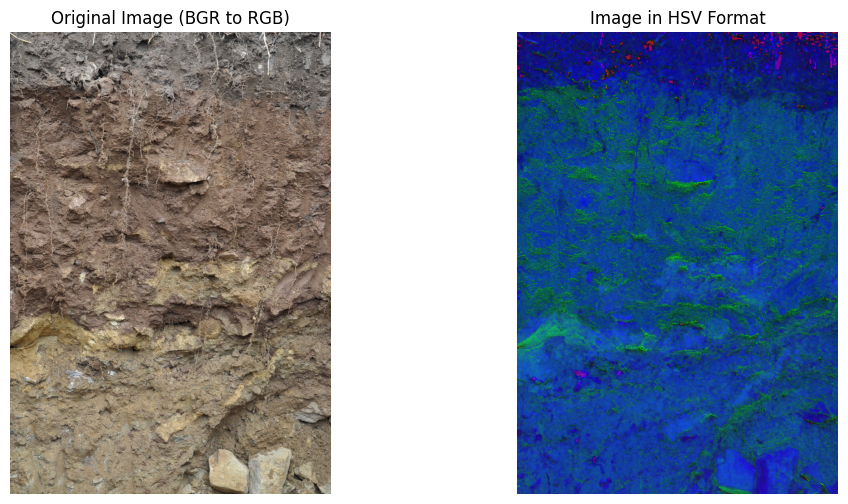

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image (BGR to RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_hsv)  # HSV visualization
plt.title('Image in HSV Format')
plt.axis('off')

plt.show()

Separate the Hue, Saturation and Value channels

In [5]:
hue, saturation, value = cv2.split(image_hsv)

split_hsv = [hue, saturation, value]

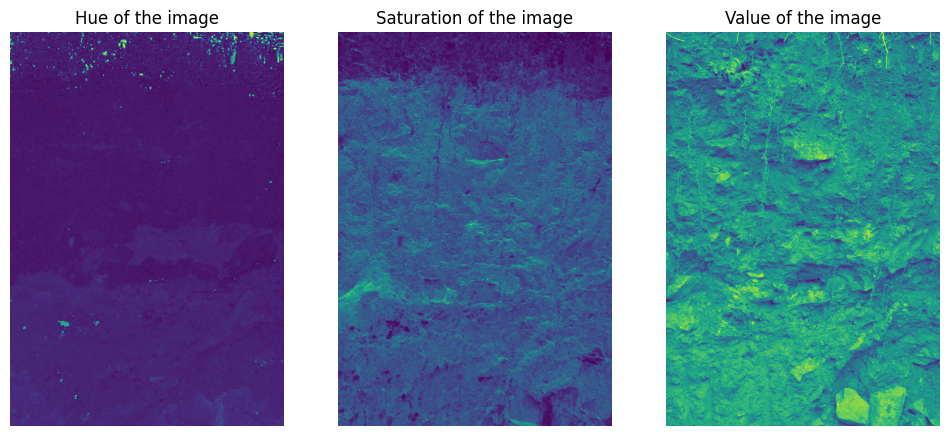

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(hue)
plt.title('Hue of the image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saturation)
plt.title('Saturation of the image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(value)
plt.title('Value of the image')
plt.axis('off')

plt.show()

Shadow removal to help the value channel yield better results

In [7]:
# Morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
background = cv2.morphologyEx(value, cv2.MORPH_CLOSE, kernel)

# Normalize image to remove shadows
split_hsv[2] = cv2.divide(value, background, scale=255)

Shadow results

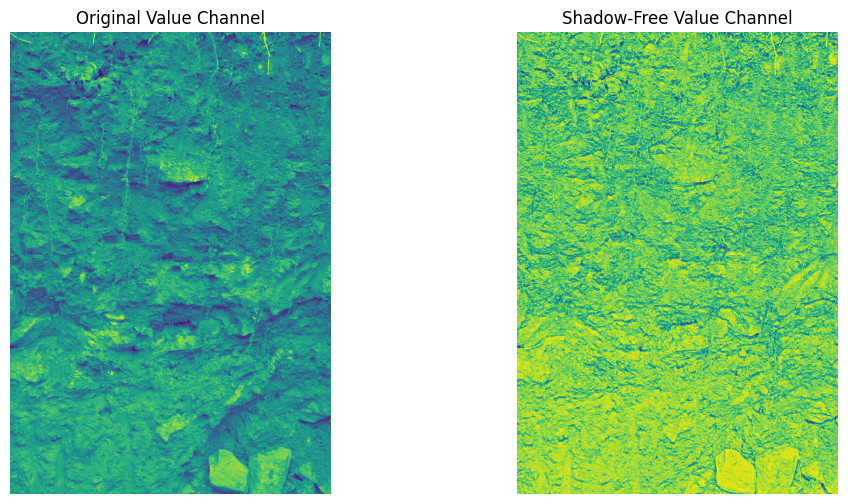

In [8]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.imshow(value)
plt.title('Original Value Channel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(split_hsv[2])
plt.title('Shadow-Free Value Channel')
plt.axis('off')

plt.show()

The Gaussian filter was used to “fuzzy” the image, to highlight the targets, to restrain detailed information, such as noise in the image, and to improve the accuracy of segmentation for the next step.

In [9]:
# Will have to fiddle around with the kernel size of the Gaussian blur

# In the article it seems like the saturation channel is the only one that gets blurred
# Or perhaps each channel are smoothed differently
for i in range(len(split_hsv)):
    split_hsv[i] = cv2.GaussianBlur(split_hsv[i], (19, 19), 0)

Display the results

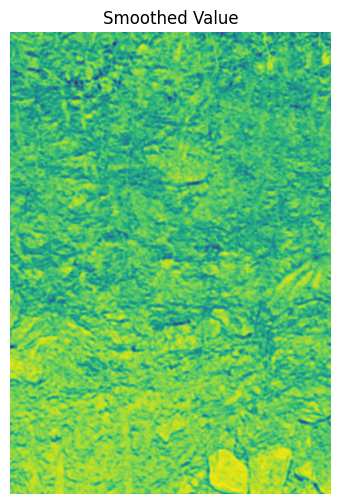

In [10]:
plt.figure(figsize=(12, 6))

plt.imshow(split_hsv[2])
plt.title('Smoothed Value')
plt.axis('off')

plt.show()

The maximum filter was used to enhance the contrast between small particle-size objects and the soil matrix in the S channel.

In [7]:
# TODO

### 2.2 Segmentation

Sobel filter (Sobel, 1990)

In [14]:
edges = []

for channel in split_hsv:
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=3)
    edges.append(cv2.magnitude(sobel_h_x, sobel_h_y))

edges = [edges_h, edges_s, edges_v]

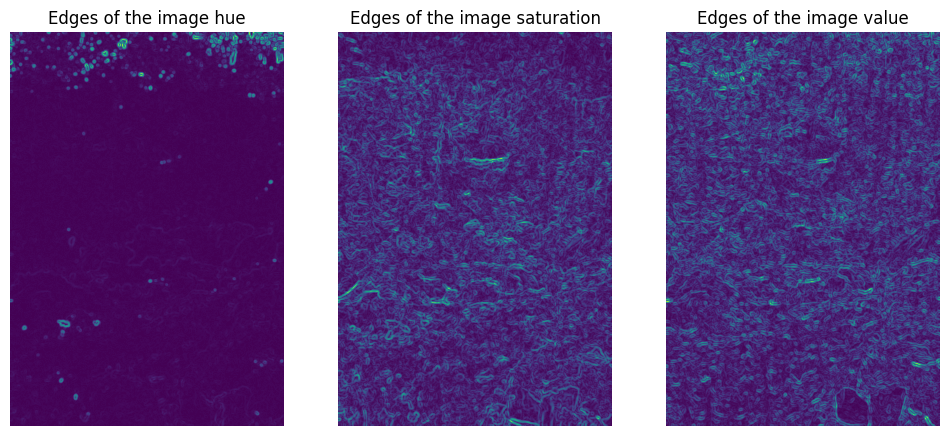

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(edges[0])
plt.title('Edges of the image hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges[1])
plt.title('Edges of the image saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges[2])
plt.title('Edges of the image value')
plt.axis('off')

plt.show()

In [16]:
# Threshold to define watershed

markers = []

for channel_edges in edges:
    _, channel_markers = cv2.threshold(channel_edges, 50, 255, cv2.THRESH_BINARY)
    markers.append(cv2.connectedComponents(np.uint8(channel_markers))[1])

Region growing watershed algorithm

In [22]:
for i in range(len(markers)): 
    markers[i] = cv2.watershed(image_hsv, markers[i])

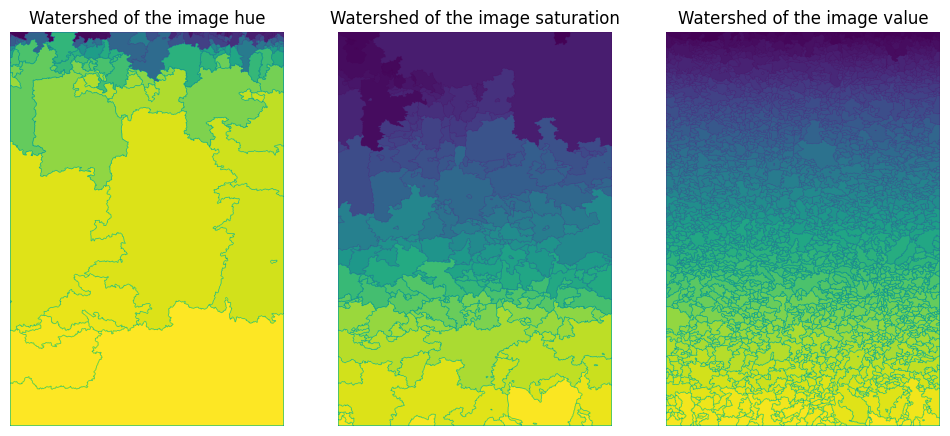

In [23]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(markers[0])
plt.title('Watershed of the image hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(markers[1])
plt.title('Watershed of the image saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(markers[2])
plt.title('Watershed of the image value')
plt.axis('off')

plt.show()

In [ ]:
segmented_channels = []

for channel_markers in markers:
    segmented_image = np.copy(image_bgr)
    segmented_image[channel_markers == -1] = [255, 0, 0]
    segmented_channels.append(segmented_image)

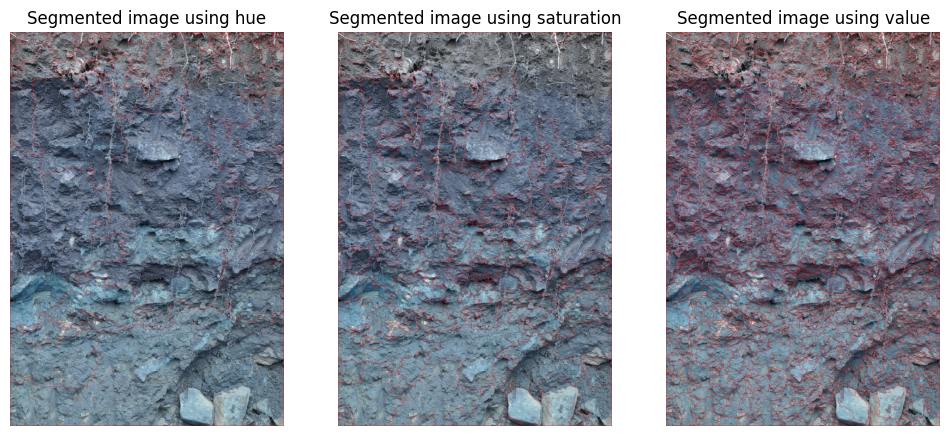

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(segmented_channels[0])
plt.title('Segmented image using hue')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmented_channels[1])
plt.title('Segmented image using saturation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(segmented_channels[2])
plt.title('Segmented image using value')
plt.axis('off')

plt.show()

### 2.3 Post-processing

In [25]:
binary_mask = (markers[2] > 0).astype(np.uint8)

# Display the results

#cv2.imshow("Segmented Image", segmented_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()